In [ ]:
# Get random image to show
import glob
from IPython.display import Image
import random
fileList = glob.glob("./BMGR_Chips/*")
rRef = random.randrange(len(fileList))
myFile = fileList[rRef]
Image(filename=myFile)

# <p style='text-align: right;'> Wild Animals</p>

## <p style='text-align: right;'> Katherine Haynes and Richi Rodriguez <br> CS 510 PA5 <br> May 8, 2020</p> 

# 1 Setup

### Setup Variables

In [12]:
dataSet = 'BMGR_Chips'
dataType = 'Day'

### Setup Google Drive

In [2]:
useGoogle = False

In [3]:
# Set directories
if useGoogle:
    from google.colab import drive
    drive.mount('/content/drive')
    dirIn = '/content/drive/My Drive/classes/cs510/pa5/' 
else:
    dirIn = './' 

### Load Libraries

In [4]:
# Load libraries
from functools import partial
import copy
import glob
import numpy as np
import itertools
import pickle
from PIL import Image
import random
import time

%matplotlib inline 
import matplotlib as mpl
from matplotlib import pyplot as plt

from hyperopt import fmin, hp, Trials, tpe, space_eval, STATUS_OK
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [5]:
# Set Tensorflow Options
tf.keras.backend.set_floatx('float32')
tf.keras.backend.set_image_data_format('channels_last')
if useGoogle:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print('Using GPU!')
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

In [6]:
# Set Plotting Sizes
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [7]:
# Set Plotting Colors
myColors = ['darkblue','slateblue','darkviolet','fuchsia','crimson',
            'orangered','goldenrod','darkolivegreen','darkslategrey']

mpl.rcParams['figure.figsize'] = (12, 10)
#myColors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Data

### Define Data Functions

In [8]:
# Function to report if variable exists
def exists(var):
    var_exists = var in locals() or var in globals()
    return var_exists

In [10]:
# Function to read in data
def read_data(dataSet='BMGR_Chips', chToSave=[]):
    
    animalList = ['Bighorn_Sheep','Bobcat','Coyote','Gray_Fox','Javelina',
                  'Mule_Deer','Raptor','White_tailed_Deer']
    animalListS = ['Bighorn','Bobcat','Coyote','Fox','Javelina',
                  'MDeer','Raptor','WTDeer']

    if dataSet == 'BMGR_Chips':
        # get filenames
        fileTry = dirIn + dataSet + '/*'
        fileList = glob.glob(fileTry)
        nSamples = len(fileList)
        if nSamples < 1:
            print('No Samples!')
            print('Tried: ',fileTry)
            return None, None, None
        
        # get filenames
        fileList = glob.glob(fileTry)
        nSamples = len(fileList)
    
        # read first image to get shape
        firstIm = Image.open(fileList[0])
        shapeIm = np.array(firstIm).shape
        nx=shapeIm[0]
        ny=shapeIm[1]
        nc=shapeIm[2]
    
        # screen out mismatching images
        nMismatch = 0
        nSamples = 0
        for file in fileList:
            imHere = Image.open(file)
            imArray = np.array(imHere)
            if imArray.shape[0] == nx:
                nSamples += 1
            else:
                nMismatch += 1
        print('{} files of {} x {} x {}'.format(nSamples,nx,ny,nc))
        print('{} files not used'.format(nMismatch))
    
        # read in images
        animalData = np.empty([nSamples,nx,ny,nc],dtype='int32')
        animalTrue = np.empty([nSamples],dtype='int32')
        animalDay = np.zeros([nSamples],dtype='int32')
        animalCount = np.zeros(len(animalList),dtype='int32')
    
        countF = 0
        for file in fileList:
            imHere = Image.open(file)
            imArray = np.array(imHere)
            if imArray.shape[0] == nx:
                animalData[countF,:,:,:] = imArray[:,:,:]
                if 'day' in file:
                    animalDay[countF] = 1
                
                countA = 0
                for animal in animalList:
                    if animal in file:
                        animalCount[countA] += 1
                        animalTrue[countF] = countA
                        continue
                    countA += 1
                countF += 1

    else:
        print("This Dataset Comes Pre-Loaded!")
        animalData=None
        animalTrue=None
        animalDay=None
        animalCount=None
        
    # return animal data, category, day/night, and count
    return animalData, animalTrue, animalDay, animalCount, animalListS

In [15]:
# Function to pull day/night data
def dayNight_data(dType, Xall, Yall, DNall, animalList):
    
    XNew = copy.copy(Xall)
    YNew = copy.copy(Yall)
    aListNew = copy.copy(animalList)
    nClassPrev = len(animalList)
    
    if dType == 'day':
        dayRef = np.where(DNall == 1)[0]
    elif dType == 'night':
        dayRef = np.where(DNall == 0)[0]
        
    if dType == 'day' or dType == 'night':
        XNew = Xall[dayRef,:,:,:]
        YNew = Yall[dayRef]

        aLabelsOrig = np.unique(Yall)
        aLabelsNew = np.unique(YNew)
        aListOrig = np.array(animalList)
        aListNew = aListOrig[aLabelsNew].tolist()
        nClassNew = len(aLabelsNew)
        aNow = np.zeros([nClassPrev])
        countL = 0
        for i in range(nClassPrev):
            if countL < nClassNew and i == aLabelsNew[countL]:
                aNow[i] = countL
                countL += 1
            else:
                aNow[i] = -1
         
        countI = 0
        for i in YNew:
            YNew[countI] = aNow[i]
            countI += 1
    else:
        nClassNew = nClassPrev
    
    print("Original Shape: {}".format(list(Xall.shape)))
    print("Day Only Shape: {}".format(list(XNew.shape)))
    print("Original Number of Labels: {}".format(nClassPrev))
    print("New Number of Labels: {}".format(nClassNew))
    print("New Animals: {}".format(aListNew))
    
    return XNew, YNew, aListNew

In [34]:
# Function to partition the data
def partition_data(Xall, Yall, animalListS, trainFraction=0.8):

    nClasses = np.unique(Yall)
    for n in nClasses:
        refArray = np.where(Yall == n)[0]
        refArray = np.random.permutation(refArray)
        nHere = round(len(refArray))
        nTrain = round(nHere*trainFraction)
        rowsTrain = refArray[:nTrain]
        rowsTest = refArray[nTrain:]
        
        XTempTr = Xall[rowsTrain,:,:,:]
        YTempTr = Yall[rowsTrain] 
        XTempTest = Xall[rowsTest,:,:,:]
        YTempTest = Yall[rowsTest]
        
        if n == nClasses[0]:
            XTrHere = XTempTr
            XTeHere = XTempTest
            YTrHere = YTempTr
            YTeHere = YTempTest
        else:
            XTrHere = np.append(XTrHere,XTempTr,axis=0)
            XTeHere = np.append(XTeHere,XTempTest,axis=0)
            YTrHere = np.append(YTrHere,YTempTr,axis=0)
            YTeHere = np.append(YTeHere,YTempTest,axis=0)
            
    # Check train/test distributions
    origClass, origCounts = np.unique(Yall,return_counts=True)
    trainClass, trainCounts = np.unique(YTrHere,return_counts=True)
    testClass, testCounts = np.unique(YTeHere,return_counts=True)
    print('Data Stats:')
    print('   Orig X Shape {}, Train X: {}, Test X: {}'.format(
        list(Xall.shape), list(XTrHere.shape), list(XTeHere.shape)))
    print('   Orig Y Shape {}, Train Y: {}, Test Y: {}'.format(
        list(Yall.shape), list(YTrHere.shape), list(YTeHere.shape)))
    
    print('')
    print('   Animal    Orig     Train      Test')
    
    sumO = np.sum(origCounts)
    sumTr = np.sum(trainCounts)
    sumTe = np.sum(testCounts)
    for i in range(len(origCounts)):
        print('   {}     {:.2f}    {:.2f}    {:.2f}'.format(
            animalListS[i], origCounts[i]/sumO*100., trainCounts[i]/sumTr*100.,
            testCounts[i]/sumTe*100.))

    return XTrHere, YTrHere, XTeHere, YTeHere

In [17]:
# Function to normalize the data
def normalize_data(XData):
    
    xsize=XData.shape
    xdim=len(xsize)
    
    nSamples=xsize[0]
    nChannels=xsize[3]
    
    if xdim == 4:
        nImgX=xsize[1]
        nImgY=xsize[2]
        XDataNew = np.empty([nSamples,nImgX,nImgY,nChannels])
        for ch in range(nChannels):
            maxD = np.max(XData[:,:,:,ch])
            minD = np.min(XData[:,:,:,ch])
            diffD = maxD-minD
            if diffD < 0.01:
                print('Min Var in Channel {}! Stopping.}'.format(ch))
                return
            XDataNew[:,:,:,ch] = (XData[:,:,:,ch] - minD)/diffD
        
    else:
        print("Expecting 4 Dimensions!")
        
    return XDataNew

In [18]:
# Function to shuffle two array
def shuffle_XY(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [19]:
# Function to plot sample image
def plot_sample_image(imData, imTrue, animalList):
    mRef = random.randrange(imData.shape[0])
    print("Plotting Sample Image: {}".format(mRef))
    
    myImage = imData[mRef,:,:,:]
    myTitle = animalList[animalTrue[mRef]]
    plt.imshow(myImage, interpolation='nearest')
    plt.title(myTitle)
    plt.show()
    
    return None

In [20]:
# Function to plot pair of sample images
def plot_sample_pair(imData1, imTrue1, imData2, imTrue2, animalList):
    
    plt.figure(figsize=(10,10))
    mRef = random.randrange(imData1.shape[0])
    print('Plotting Sample Training Image: {}'.format(mRef))
    myImage = imData1[mRef,:,:,:]
    myTitle = 'Training: ' + animalList[imTrue1[mRef]]
    plt.subplot(1,2,1)
    plt.imshow(myImage, interpolation='nearest')
    plt.title(myTitle)
    
    mRef = random.randrange(imData2.shape[0])
    print('Plotting Sample Testing Image: {}'.format(mRef))
    myImage = imData2[mRef,:,:,:]
    myTitle = 'Testing: ' + animalList[imTrue2[mRef]]
    plt.subplot(1,2,2)
    plt.imshow(myImage, interpolation='nearest')
    plt.title(myTitle)
    plt.show()
    
    return None

In [21]:
# Plot confusion matrix
def plot_confusion_matrix(cm, class_names, cTitle='Confusion Matrix'):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
  
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(cTitle)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = 0.90
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
    return figure

### Read in the data

In [22]:
readData = False
saveData = True
saveDataFile = dirIn + 'save/' + dataSet + '_Loaded.pkl'

In [23]:
# Read in the data
if readData:
    animalData, animalTrue, animalDay, animalCount, animalListS = read_data(dataSet)
    
    if saveData:
        with open(saveDataFile, 'wb') as handle:
            pickle.dump([animalData, animalTrue, animalDay, 
                         animalCount, animalListS], 
                        handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Saved File: ",saveDataFile)

else:
    with open(saveDataFile, 'rb') as handle:
        allTemp = pickle.load(handle)
    animalData = allTemp[0]
    animalTrue = allTemp[1]
    animalDay = allTemp[2]
    animalCount = allTemp[3]
    animalListS = allTemp[4]
    print("Loaded Data")
    
    nSamples = animalData.shape[0]
    nx = animalData.shape[1]
    ny = animalData.shape[2]
    nc = animalData.shape[3]
    print('   {} files of {} x {} x {}'.format(nSamples,nx,ny,nc))

Loaded Data
   1712 files of 256 x 256 x 3


### Select All, Day, or Night

In [24]:
dataType = 'day'

In [25]:
# Pull out day/night
animalData, animalTrue, animalListS = \
    dayNight_data(dataType,animalData,animalTrue,animalDay,animalListS)

Original Shape: [1712, 256, 256, 3]
Day Only Shape: [1102, 256, 256, 3]
Original Number of Labels: 8
New Number of Labels: 7
New Animals: ['Bighorn', 'Bobcat', 'Coyote', 'Javelina', 'MDeer', 'Raptor', 'WTDeer']


### Plot sample image

Plotting Sample Image: 196


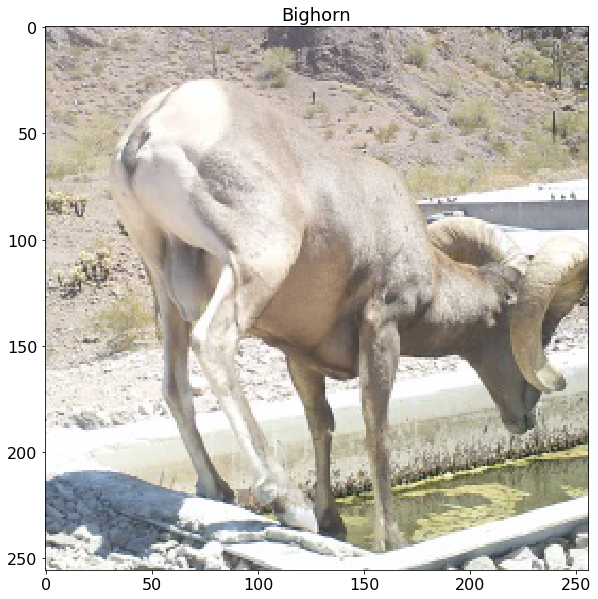

In [26]:
if True:
    plot_sample_image(animalData,animalTrue,animalListS)

### Make a train/test split

In [35]:
XTrain, YTrain, XTest, YTest = partition_data(animalData, animalTrue, animalListS)

Data Stats:
   Orig X Shape [1102, 256, 256, 3], Train X: [882, 256, 256, 3], Test X: [220, 256, 256, 3]
   Orig Y Shape [1102], Train Y: [882], Test Y: [220]

   Animal    Orig     Train      Test
   Bighorn     18.15    18.14    18.18
   Bobcat     9.07    9.07    9.09
   Coyote     9.07    9.07    9.09
   Javelina     9.07    9.07    9.09
   MDeer     9.07    9.07    9.09
   Raptor     36.48    36.51    36.36
   WTDeer     9.07    9.07    9.09


### Shuffle the data

In [36]:
shuffle_XY(XTrain, YTrain)
shuffle_XY(XTest, YTest)
print("Shuffled Data!")

Shuffled Data!


### Normalize the data

In [37]:
XTrainN = normalize_data(XTrain)
XTestN = normalize_data(XTest)

Plotting Sample Training Image: 91
Plotting Sample Testing Image: 82


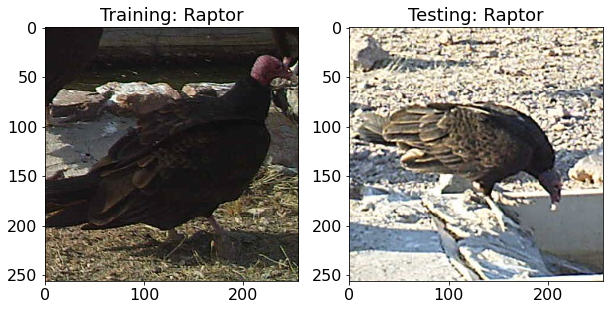

In [38]:
plot_sample_pair(XTrainN,YTrain,XTestN,YTest,animalListS)

# 2 CNN Hyperparameter Search Space


### Network Architecture Features 
Architecture features are options associated with the neural network setup. <br>
This search space consists of three elements:

* <b>Dropout Rate</b><br>
Use a uniform distribution in finding an appropriate dropout value. <br>
hp.uniform('dropout', 0.0, 0.4) <br><br>

* <b>Number of Convolutional Layers</b><br>
Determine the number of hidden convolutional layers, ranging from 1 to 8.<br>
hp.choice('nconv2d', range(8)) <br><br>

* <b>Pooling Layer</b><br>
Select whether to add a pooling layer after the convolutional layer. <br>
hp.choice('pool',[0,1]) <br>


### Network Parameters
Parameters are options associated with the CNN implementation. <br>
This search space consists of six elements:

* <b>Batch Size</b><br>
Vary the batch size fed for each gradient update from 100 to 700, incrementing by 5.<br>
hp.quniform('batch_size', 100, 700, 5)<br><br>

* <b>Beta 1</b><br>
Vary the exponential decay rate for the 1st moment estimates, ranging from 0.8 to 1.0.<br>
hp.uniform('beta_1', 0.8, 1.0)<br><br>

* <b>Beta 2</b><br>
Vary the exponential decay rate for the 2nd moment estimates, ranging from 0.9 to 1.0.<br>
hp.uniform('beta_2', 0.9, 1.0)<br><br>

* <b>Convolutional Kernel X Size</b><br>
Vary the size of the convolutional kernel x-size, ranging from 2 to 5. <br>
hp.choice('nkernelx', range(2,6))<br><br>

* <b>Convolutional Kernel Y Size</b><br>
Vary the size of the convolutional kernel y-size, ranging from 2 to 5. <br>
hp.choice('nkernely', range(2,6))<br><br>

* <b>Convolutional Stride X Size</b><br>
Vary the stride of the convolutional kernel in the x-direction, ranging from 1 to 5.<br>
hp.choice('stridex', range(1,5))<br><br>

* <b>Convolutional Stride Y Size</b><br>
Vary the stride of the convolutional kernel in the y-direction, ranging from 1 to 5.<br>
hp.choice('stridey', range(1,5))<br><br>

* <b>Initial Accumulator Value</b><br>
Vary the initial accumulator value for the Adagrad optimizer using a multiplier on the default value of 0.1.
hp.loguniform('iacc_mult', -0.2, 0.2)<br><br>

* <b>Learning Rate</b><br>
Vary the learning rate, using a loguniform scale to make it vary exponentially in a multiplicative fashion. <br>
hp.loguniform('lr_mult', -0.5, 0.5) <br><br>

* <b>Number of Epochs</b><br>
Vary the number of epochs for training, ranging from 10 to 200.<br>
hp.choice('nepochs', [10,20,40,60,80,100,120,150,200])<br><br>

* <b>Number of Hidden Units</b><br>
Vary the number of hidden units, specifying the number using a range.<br>
hp.choice('nhidden', range(8,160) <br><br>

* <b>Optimizer</b><br>
Select from three different optimizer options: Adagrad, Adam, and NAdam. <br>
hp.choice('optimizer', ['Adagrad','Adam','Nadam']) <br><br>



## Search Method: [Hyperopt](http://jaberg.github.io/hyperopt/)
The data pre-processing, network building components, and model parameters will be searched using [Hyperopt](http://proceedings.mlr.press/v28/bergstra13.pdf).


## Search Evaluation
I will use both a train/test split and cross-validation to evaluate my models.  The hyperparameter optimization will be conducted on the training split; however, to find the best options and avoid overfitting I will use 3-fold cross-validation in the parameter searches.  Once the optimal options and parameters have been found using the training dataset, the final model selection will be based on model performance for the testing split.  The top ten models from a guided search on the training data (using cross-validation) will then be evaluated on the hold-out testing data for final model recommendations.

## Search Definition

In [39]:
# SEARCH SPACE DEFINITION
space = {
    'batch_size': hp.quniform('batch_size', 100, 200, 5),
    'nepochs': hp.choice('nepochs', [10,20,40,60,80,100,120,150,200]),
    'nconv2d': hp.choice('nconv2d', range(1,5)),
    'nunitsin': hp.choice('nunitsin', range(8,24)),
    'nkernelxin': hp.choice('nkernelxin', range(2,4)),
    'nkernelyin': hp.choice('nkernelyin', range(2,4)),
    'poolin': hp.choice('poolin', [0,1]),
    'nunits1': hp.choice('nunits1', range(16,32)),
    'nkernelx1': hp.choice('nkernelx1', range(2,4)),
    'nkernely1': hp.choice('nkernely1', range(2,4)),
    'stridex1': hp.choice('stridex1', range(1,4)),
    'stridey1': hp.choice('stridey1', range(1,4)),
    'drop1': hp.choice('drop1', [0,1]),
    'dropv1': hp.uniform('drop1v', 0.01, 0.2),
    'pool1': hp.choice('pool1', [0,1]),
    'nunits2': hp.choice('nunits2', range(16,32)),
    'nkernelx2': hp.choice('nkernelx2', range(2,5)),
    'nkernely2': hp.choice('nkernely2', range(2,5)),
    'stridex2': hp.choice('stridex2', range(1,4)),
    'stridey2': hp.choice('stridey2', range(1,4)),
    'drop2': hp.choice('drop2', [0,1]),
    'dropv2': hp.uniform('drop2v', 0.01, 0.2),
    'pool2': hp.choice('pool2', [0,1]),
    'nunits3': hp.choice('nunits3', range(16,32)),
    'nkernelx3': hp.choice('nkernelx3', range(2,5)),
    'nkernely3': hp.choice('nkernely3', range(2,5)),
    'stridex3': hp.choice('stridex3', range(1,5)),
    'stridey3': hp.choice('stridey3', range(1,5)),
    'drop3': hp.choice('drop3', [0,1]),
    'dropv3': hp.uniform('drop3v', 0.01, 0.2),
    'pool3': hp.choice('pool3', [0,1]),
    'nunits4': hp.choice('nunits4', range(16,168)),
    'nkernelx4': hp.choice('nkernelx4', range(2,6)),
    'nkernely4': hp.choice('nkernely4', range(2,6)),
    'stridex4': hp.choice('stridex4', range(1,5)),
    'stridey4': hp.choice('stridey4', range(1,5)),
    'drop4': hp.choice('drop4', [0,1]),
    'dropv4': hp.uniform('drop4v', 0.01, 0.2),
    'pool4': hp.choice('pool4', [0,1]),
    'nunitslc': hp.choice('nunitslc', range(4,10)),
    'nunitsout': hp.choice('nunitsout', range(6,16)),
    'optimizer': hp.choice('optimizer', ['Adagrad','Adam','Nadam']),
    'beta_1': hp.uniform('beta_1', 0.8, 1.0),
    'beta_2': hp.uniform('beta_2', 0.9, 1.0),
    'iacc_mult': hp.loguniform('iacc_mult', -0.2, 0.2),
    'lr_mult': hp.loguniform('lr_mult', -0.5, 0.5)
}

# 3 CNN Model Setup

### Build Functions

In [40]:
# BUILD MODEL FUNCTION
def build_model(params, nShapeX, nShapeY, nFeatures, nClasses,
               useMetrics=False):

    METRICS = [
        tf.keras.metrics.Accuracy(name='accuracy'),
        tf.keras.metrics.MeanAbsoluteError(name='MAE'),
        tf.keras.metrics.MeanSquaredError(name='MSE'),
        tf.keras.metrics.SparseCategoricalCrossentropy(name='entropy')
    ]
        
    # Save information from params
    opt = params['optimizer']
    if opt == 'Adagrad':
        myOpt = tf.keras.optimizers.Adagrad(
                    learning_rate=params['lr_mult']*0.001,
                    initial_accumulator_value=params['iacc_mult']*0.1)
    elif opt == 'Adam':
        myOpt = tf.keras.optimizers.Adam(
                    learning_rate=params['lr_mult']*0.001, 
                    beta_1=params['beta_1'], beta_2=params['beta_2'])
    elif opt == 'Nadam':
        myOpt = tf.keras.optimizers.Nadam(
                    learning_rate=params['lr_mult']*0.001,
                    beta_1=params['beta_1'], beta_2=params['beta_2'])
    else:
        print("UNKNOWN OPTIMIZER. STOPPING.")
        sys_exit()

    
    # Define model
    model = Sequential()
    
    # ...input layer
    model.add(layers.Conv2D(params['nunitsin'], 
                            (params['nkernelxin'], params['nkernelyin']),
                            activation='relu',
                            input_shape=(nShapeX, nShapeY, nFeatures)))
    
    #if params['poolin'] == 1:
    #    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    # ...middle layers
    nLayers = params['nconv2d']
    for i in range(1,nLayers+1):
        
        nuStr = 'nunits' + str(i)
        # ...if last conv2D layer, use specific weights
        if i == nLayers:
            nuStr = 'nunitslc'
            
        nkxStr = 'nkernelx' + str(i)
        nkyStr = 'nkernely' + str(i)
        stxStr = 'stridex' + str(i)
        styStr = 'stridey' + str(i)
        dStr = 'drop' + str(i)
        dvStr = 'dropv' + str(i)
        pStr = 'pool' + str(i)
    
        # ...do not add another layer if it goes
        # ...beyond current size
        outShape = model.layers[-1].output_shape
        haveX = outShape[1]
        haveY = outShape[2]
        if haveX < params[nkxStr] or haveY < params[nkyStr]:
            break
    
        model.add(layers.Conv2D(params[nuStr],
                               (params[nkxStr],params[nkyStr]),
                               activation='relu',
                               strides=(params[stxStr],params[styStr])))

        if params[dStr] == 1:
            model.add(layers.Dropout(params[dvStr]))
        
        if params[pStr] == 1:
            model.add(layers.MaxPooling2D((2, 2), padding='same'))

        
    # ...output layer
    model.add(layers.Flatten())
    model.add(layers.Dense(params['nunitsout'], activation='relu'))
    model.add(layers.Dense(nClasses))
    
    # Compile Model
    if not useMetrics:
        METRICS = ['accuracy']
    model.compile(optimizer=myOpt, 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=METRICS)
    
    return model

In [41]:
# TRAIN MODEL FUNCTION
def train_model(params, X, Y, nCVSplits=3, verbose=False):
      
    # Set the data
    nEpochs = params['nepochs']
    sBatch = int(params['batch_size'])
    
    # Make pre-processing selections
    #X_, _ = select_data(X, Temp, params)
    nImageX = X.shape[1]
    nImageY = X.shape[2]
    nFeatures = X.shape[3]
    nClasses = len(np.unique(Y))

    # Build the model
    model = build_model(params, nImageX, nImageY, nFeatures, nClasses)
    if verbose:
        model.summary()

    # Train using cross-validation
    dCV = StratifiedKFold(n_splits=nCVSplits, shuffle=True)
    dCV_iter = dCV.split(X, Y)
    history = {}
    for train_index, test_index in dCV_iter:
        x_train,x_test=X[train_index],X[test_index]
        y_train,y_test=Y[train_index],Y[test_index]
        histNow = model.fit(x_train, y_train, epochs=nEpochs, 
                            batch_size=sBatch, verbose=0,
                            validation_data=(x_test,y_test))
        
        for key, val in histNow.history.items():
            if key in history:
                tempL = history[key]
                count=0
                for vh in val:
                    tempL[count].append(vh)
                    count+=1
            else:
                tempL = []
                for vh in val:
                    tempL.append([vh])
                history[key] = tempL
        
    # Create mean and standard deviation of cv results
    myItems = list(history.items())
    for key, val in myItems:
        newMean = []
        newStd = []
        for i in range(nEpochs):
            newMean.append(np.mean(val[i]))
            newStd.append(np.std(val[i],ddof=1))
            
        history[key] = newMean
        newKey = key + '_std'
        history[newKey] = newStd
    history['epoch'] = np.arange(1,nEpochs+1)
    
    # Clean up environment
    del model
    tf.keras.backend.clear_session()
    
    return history

In [42]:
# TEST MODEL FUNCTION
def test_model(params, XTrain, YTrain, 
               XTest, YTest, nCVSplits=3, 
               verbose=False, YPrint=False, YConf=False, 
               YConfTitle=None,YConfSave=None,
               animalList=animalListS):

    # Set the data
    nEpochs = params['nepochs']
    sBatch = int(params['batch_size'])
    
    # Make pre-processing selections
    nImageX = XTrain.shape[1]
    nImageY = XTrain.shape[2]
    nFeatures = XTrain.shape[3]
    yclasses = np.unique(YTrain)
    nClasses = len(np.unique(YTrain))

    # Build the model
    model = build_model(params, nImageX, nImageY, nFeatures, nClasses)
    if verbose:
        model.summary()
        
    # Train using cross-validation
    dCV = StratifiedKFold(n_splits=nCVSplits, shuffle=True)
    dCV_iter = dCV.split(XTrain, YTrain)
    history = {}
    for train_index, test_index in dCV_iter:
        x_train,x_test=XTrain[train_index],XTrain[test_index]
        y_train,y_test=YTrain[train_index],YTrain[test_index]
        histNow = model.fit(x_train, y_train, epochs=nEpochs, 
                            batch_size=sBatch, verbose=0,
                            validation_data=(x_test,y_test))
        for key, val in histNow.history.items():
            if key in history:
                tempL = history[key]
                count=0
                for vh in val:
                    tempL[count].append(vh)
                    count+=1
            else:
                tempL = []
                for vh in val:
                    tempL.append([vh])
                history[key] = tempL
    
    # Create mean and standard deviation of cv results
    myItems = list(history.items())
    for key, val in myItems:
        newMean = []
        newStd = []
        for i in range(nEpochs):
            newMean.append(np.mean(val[i]))
            newStd.append(np.std(val[i],ddof=1))
            
        history[key] = newMean
        newKey = key + '_std'
        history[newKey] = newStd
    history['epoch'] = np.arange(1,nEpochs+1)
    
    # Evaluate
    resultsList = model.evaluate(XTest, YTest, verbose=0)
    results = dict_Results(resultsList)
    
    # Make Predictions
    probability_model = tf.keras.Sequential([model,
                                tf.keras.layers.Softmax(dtype='float64')])
    y_predict = probability_model(XTest).numpy()
    y_classes = yclasses[y_predict.argmax(axis=1)]
    if YPrint:
        print("Number of Cases: {}".format(YTest.shape[0]))
        countC = 0
        for c in yclasses:
            nHere = len(np.where(YTest == c)[0])
            nHereP = len(np.where(y_classes == c)[0])
            print('   {} True: {}, Predicted: {}'.format(
                animalList[countC], nHere, nHereP))
            countC += 1

    # Plot confusion matrix
    if YConf:
        cmatrix = confusion_matrix(YTest, y_classes)
        disp = plot_confusion_matrix(cmatrix, animalList,
                                     cTitle=YConfTitle) 
        
        if YConfSave:
            plt.savefig(YConfSave,bbox_inches='tight')

    # Clean up environment
    #del model
    #tf.keras.backend.clear_session()

    return results, history, y_predict, model

### TPE Functions

In [43]:
# CONVERT RESULTS TO DICTIONARY
def dict_Results(results):
    
    resultsDict = {}
    metrics = ['loss','accuracy']
    nMetrics = len(metrics)
    
    count=0
    for m in metrics:
        resultsDict[m] = results[count]
        count+=1
        
    return resultsDict

In [44]:
# TPE OPTIMIZE FUNCTION
def hyperopt_f(params, X, Y, nPrintInfo=1, trainVerbose=False,
               saveFreq=10, saveFile='hpResults'):
    
    global bestA, countA, paramA, spaceA, trialsA, timeA
    countA += 1  
    if countA % nPrintInfo == 0:
        print()
        print('Count: {}, Params: {}'.format(countA, params))
        
    history = train_model(params, X, Y, verbose=trainVerbose)
    balAcc = history['val_accuracy'][-1]
    if balAcc > bestA:
        bestA = balAcc
        spaceA = params
        
    if countA % nPrintInfo == 0:
        print()
        print('  Best: {:.2f}, Acc: {:.2f}'.format(bestA*100., balAcc*100.))

    if countA % saveFreq == 0:
        fileNow = saveFile + str(countA) + 'p.pkl'
        with open(fileNow, 'wb') as handle:
            timeT = time.time() - timeA
            pickle.dump([bestA, spaceA, trialsA, timeT], handle,
                       protocol=pickle.HIGHEST_PROTOCOL)
            
    return {'loss': -balAcc, 'status': STATUS_OK} 

In [45]:
# TPE RUN TRIALS FUNCTION
def run_trials(hyperopt_f, X, Y, 
               nMaxEvals=10, nPrintEvals=1,
               saveFreq=10, saveFile='hpResults',
               verbose=True, trainVerbose=False):

    global bestA, spaceA, trialsA, timeA
    
    fpartial = partial(hyperopt_f, X=XTrain, Y=YTrain,
                       nPrintInfo=nPrintEvals, 
                       trainVerbose=trainVerbose,
                       saveFreq=saveFreq, saveFile=saveFile)
    best = fmin(fpartial, spaceA, algo=tpe.suggest,
                max_evals=nMaxEvals, trials=trialsA)
    
    bestSpace = space_eval(spaceA, best)
    timeT = time.time() - timeA
    
    if saveFreq != 0:
        fileNow = saveFile + str(nMaxEvals) + '.pkl'
        with open(fileNow, 'wb') as handle:
            pickle.dump([bestA, bestSpace, trialsA, timeT], handle,
                       protocol=pickle.HIGHEST_PROTOCOL)
            
    if verbose:
        print('')
        print('--------------------------------------')
        print('Finished Search in {:.3f}s'.format(timeT))
        print('Best Parameters: {}'.format(bestSpace))
        print('Best CV Train Accuracy: {:.3f}'.format(bestA*100.))
        print('')

    return trialsA

### Plot Functions

In [46]:
# PLOT MODEL DIAGRAM FROM HYPERSPACE
def plot_model_diagram(hyperspace, nX=256, nY=256, nChannel=3, nClass=8,
                       file_name_prefix=''):
    
    model = build_model(hyperspace, nX, nY, nChannel, nClass)
    model.summary()
    if file_name_prefix != '':
        plot_model(
            model,
            to_file='{}.png'.format(file_name_prefix),
            show_shapes=True)

        print("Saved model visualization to {}.png".format(file_name_prefix))
    else:
        plot_model(model, show_shapes=True)
        
    del model

In [47]:
# PLOT LOSS
def plot_loss(history, label='', n=0):
    plt.semilogy(history['epoch'], history['loss'], 
                 color=myColors[n], label='Train '+label)
    plt.semilogy(history['epoch'], history['val_loss'],
                color=myColors[n], label='Val '+label, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [48]:
# PLOT ACCURACY
def plot_accuracy(history, label='', n=0, balanced=False):
    ep1 = history['epoch']
    acc1 = np.array(history['accuracy'])*100.
    acc2 = np.array(history['val_accuracy'])*100.
    plt.plot(ep1, acc1, color=myColors[n], label='Train '+label)
    plt.plot(ep1, acc2, color=myColors[n], label='Val '+label, linestyle='--')
    
    if balanced:
        acc3 = np.array(history['balAcc'])*100.
        acc4 = np.array(history['val_balAcc'])*100.
        plt.plot(ep1, acc3, color=myColors[n+4], label='BAcc Train '+label)
        plt.plot(ep1, acc4, color=myColors[n+4], label='BAcc Val '+label, linestyle='--')
        plt.legend(ncol=2)
    else:
        plt.legend()
        
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')


### Testing Functions

In [51]:
plotBase = False
trainBase = False
testBase = False
saveConf = False

testBest = True
testBestNum = 1

In [57]:
# CREATE BASE MODEL
if plotBase or trainBase or testBase or testBest:
    space_base = {
    'batch_size': 300, 'nepochs': 1, 'nconv2d': 4, 'nunitsin': 16,
    'nkernelxin': 2, 'nkernelyin': 3, 'poolin': 1, 'nunits1': 32,
    'nkernelx1': 3, 'nkernely1': 4, 'stridex1': 1, 'stridey1': 1,
    'drop1': 1, 'dropv1': 0.1, 'pool1': 0,
    'nunits2': 100, 'nkernelx2': 2, 'nkernely2': 3, 'stridex2': 1,
    'stridey2': 2, 'drop2': 0, 'dropv2': 0., 'pool2': 1,
    'nunits3': 64, 'nkernelx3': 2, 'nkernely3': 2, 'stridex3': 1, 
    'stridey3': 1, 'drop3': 1, 'dropv3': 0.2, 'pool3': 0,
    'nunits4': 128, 'nkernelx4': 2, 'nkernely4': 2, 'stridex4': 1,
    'stridey4': 1, 'drop4': 0, 'dropv4': 0.0, 'pool4': 0,
    'nunitslc':8, 'nunitsout': 72, 'optimizer': 'Adam',
    'beta_1': 0.9, 'beta_2': 0.99, 'iacc_mult': 1.0, 'lr_mult': 1.0,
    }
    
    animal_best1 = {'batch_size': 170.0, 'beta_1': 0.9880689425914697, 
                   'beta_2': 0.9483786176573927, 'drop1': 1, 'drop2': 1, 
                   'drop3': 1, 'drop4': 1, 'dropv1': 0.17909810720952316, 
                   'dropv2': 0.12282732249415412, 'dropv3': 0.18687601600294526, 
                   'dropv4': 0.08695402915299792, 'iacc_mult': 0.8692352164017315, 
                   'lr_mult': 0.863931203225306, 'nconv2d': 4, 'nepochs': 200, 
                   'nkernelx1': 2, 'nkernelx2': 4, 'nkernelx3': 4, 'nkernelx4': 3, 
                   'nkernelxin': 3, 'nkernely1': 2, 'nkernely2': 3, 'nkernely3': 4, 
                   'nkernely4': 3, 'nkernelyin': 3, 'nunits1': 22, 'nunits2': 21, 
                   'nunits3': 28, 'nunits4': 44, 'nunitsin': 8, 'nunitslc': 6, 
                   'nunitsout': 14, 'optimizer': 'Nadam', 'pool1': 1, 'pool2': 1, 
                   'pool3': 0, 'pool4': 1, 'poolin': 0, 'stridex1': 3, 'stridex2': 3, 
                   'stridex3': 2, 'stridex4': 3, 'stridey1': 3, 'stridey2': 3, 
                   'stridey3': 1, 'stridey4': 2}
    
    animal_best2 = {'batch_size': 170.0, 'beta_1': 0.9705003223422017, 
                    'beta_2': 0.9651912338260621, 'drop1': 1, 'drop2': 1, 'drop3': 1, 
                    'drop4': 1, 'dropv1': 0.1971512575481152, 
                    'dropv2': 0.1285697675258726, 'dropv3': 0.01991012625142069, 
                    'dropv4': 0.0861438846461997, 'iacc_mult': 0.8461424499924165, 
                    'lr_mult': 0.9807841076366997, 'nconv2d': 4, 'nepochs': 200, 
                    'nkernelx1': 2, 'nkernelx2': 4, 'nkernelx3': 4, 'nkernelx4': 3, 
                    'nkernelxin': 3, 'nkernely1': 3, 'nkernely2': 3, 'nkernely3': 4, 
                    'nkernely4': 3, 'nkernelyin': 3, 'nunits1': 22, 'nunits2': 21, 
                    'nunits3': 28, 'nunits4': 44, 'nunitsin': 8, 'nunitslc': 6, 
                    'nunitsout': 14, 'optimizer': 'Nadam', 'pool1': 1, 'pool2': 1, 
                    'pool3': 0, 'pool4': 1, 'poolin': 0, 'stridex1': 3, 'stridex2': 3, 
                    'stridex3': 2, 'stridex4': 3, 'stridey1': 3, 'stridey2': 3, 
                    'stridey3': 1, 'stridey4': 1}


In [58]:
# PLOT BASE MODEL
if plotBase:
    
    plot_model_diagram(space_base, file_name_prefix="cnn_model_base")

In [59]:
# TRAIN BASE MODEL AND PLOT LOSS/ACCURACY
if trainBase and not exists('myHist'):
    myHist = train_model(space_base, XTrainN, YTrain)
    
if trainBase:
    f = plt.figure(figsize=(20,12))
    ax = f.add_subplot(121)
    plot_loss(myHist, label='CNN', n=0)
    
    ax2 = f.add_subplot(122)
    plot_accuracy(myHist, label='CNN', n=0)

In [60]:
# BUILD AND TEST BASE MODEL
if testBase:
    if saveConf:
        myTitle = dataSet + 'Confusion Matrix'
    else:
        myTitle = None
    myResults, myHistory, myPredict, myModel = test_model(
        space_base, XTrainN, YTrain, XTestN, YTest,
        YPrint=True, YConf=True, YConfTitle=myTitle)

In [ ]:
# BUILD, TEST and SAVE BEST MODEL
if testBest:
    if testBestNum == 1:
        print("Using Animal_Best1.")
        myBase = animal_best1
    else:
        print("Using Animal_Best2.")
        myBase = animal_best2

    myResults, myHistory, myPredict = test_model(
        myBase, XTrain, YTrain, XTest, YTest)
    fileNow = dirIn + 'save/' + dataSet + '_Best' +int(testBestNum) + 'TestResults.pkl'
    with open(fileNow, 'wb') as handle:
            pickle.dump([myResults, myHistory, myPredict, YTest], handle,
                       protocol=pickle.HIGHEST_PROTOCOL)
    print('Saved File: ', fileNow)

Using Animal_Best1.


# 4 TPE Hyperparameter Search

To perform a hyperparameter search in order to find the best neural network, Hyperopt implements the Tree-structured Parzen Estimator (TPE).  TPE is a sequential model-based optimization approach that sequentially constructs models to approximate the performance of hyperparameters based on historical measurements ([Claesen et al, 2014](https://optunity.readthedocs.io/en/latest/user/solvers/TPE.html#tpe2011)).

### Perform Search

In [ ]:
doSearch = True
nMaxEvals = 1
nPrintEvals = 1

saveSearch = True
saveFreq = 1
saveFile = dirIn + 'save/' + dataSet + '_' + dataType
trainVerbose = True

In [ ]:
# HYPERPARAMETER SEARCH USING HYPEROPT TPE
if doSearch:
    bestA=0
    countA=0
    paramsA={}
    spaceA=space
    timeA=time.time()
    trialsA=Trials()
    
    nnTrials = run_trials(hyperopt_f, XTrainN, YTrain, 
                          nMaxEvals=nMaxEvals, nPrintEvals=nPrintEvals,
                          saveFreq=saveFreq, saveFile=saveFile,
                          trainVerbose=trainVerbose)

### Calculate Test Accuracies
To investigate search results and find the best model, calculate the performance of the select top trials on the test dataset. This will save the output into another pickle file containing the training and testing output that can be used to create plots and tables.

In [ ]:
calcTestAcc = True
calcTopN = 12

printNCheck = 1
inTrialFile = dirIn + 'save/' + dataSet + '.pkl'
saveTestFile = dirIn + 'save/' + dataSet + '_TestResults' + str(calcTopN) + '.pkl'

In [ ]:
# Open Trial Results and Save Test Results
if calcTestAcc:
    with open(inTrialFile, 'rb') as handle:
        allTemp = pickle.load(handle)
        
    bestA = allTemp[0]
    bestSpace = allTemp[1]
    allTrials = allTemp[2]
    
    nTrials = len(allTrials.trials)
    nTop = min(nTrials, calcTopN)
    
    topAcc = []
    topParams = []
    minAcc = -999
    for mt in allTrials.trials:
        accHere = -mt['result']['loss']  
        if len(topAcc) < nTop:
                topAcc.append(accHere)
                pHere = mt['misc']['vals']
                for key, val in pHere.items():
                    pHere[key] = val[0]
                pNow = space_eval(space, pHere)
                topParams.append(pNow)
                
        elif accHere > minAcc:
                topAcc[nTop-1] = accHere
                pHere = mt['misc']['vals']
                for key,val in pHere.items():
                    pHere[key] = val[0]
                pNow = space_eval(space, pHere)
                topParams[nTop-1] = pNow

        if (len(topAcc) > 2):
            topAcc, topParams = zip(*sorted(zip(
                   topAcc, topParams), 
                   reverse=True, key=lambda x: x[0]))
            topAcc = list(topAcc)
            topParams = list(topParams)

        minAcc = min(topAcc)

    topTest = []
    topResults = []
    topHistory = []
    topPredict = []
    for i in range(nTop):
        tResults, tHistory, tPredict = test_model(topParams[i], 
                    XTrain, YTrain, XTest, YTest)
        topTest.append(tResults['balAcc'])
        topResults.append(tResults)
        topHistory.append(tHistory)
        topPredict.append(tPredict)
        
        if ((i % printNCheck) == 0):
            print('Number {}: CV= {:.3f}, Test= {:.3f}'.format(
               i, topAcc[i], topTest[i]))
  
    topTest, topAcc, topParams, topResults, topHistory, topPredict = \
        zip(*sorted(zip(topTest, topAcc, topParams, topResults, 
                    topHistory, topPredict), 
                    reverse=True, key=lambda x: x[0]))
    
    with open(saveTestFile, 'wb') as handle:
          pickle.dump([list(topAcc), list(topTest), list(topParams),
                       list(topResults), list(topHistory), list(topPredict), YTest], 
                       handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('Created File: ',saveTestFile)